# Week 8 - Decision Trees

### Aims

By the end of this notebook you will be able to understand 

>* The Basics of Decision Trees
>* Gini Impurity
>* Classification Trees
>* Ensemble Models and Majority Voting


1. [**Setup**]

2. [**Basics of Decision Trees**]

3. [**Gini Impurity**]

4. [**Ensemble Models**]

5. [**Breast Cancer Data for Binary Example**]

In this WS we will be exploring the basics of decision trees. NOTE THAT, for the simplicity we did not use any data partitioning in below for toy data examples. But for the real data set, we have the data splitting procedure as a general procedure (Breast cancer data example). 

As usual, during workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

## Reminder on Terminology

- **Root node**: no incoming edge, zero, or more outgoing edges.

- **Internal node**: one incoming edge, two (or more) outgoing edges.

- **Leaf node**: each leaf node is assigned a class label if nodes are pure; otherwise, the class label is determined by majority vote.

- **Parent and child nodes**: If a node is split, we refer to that given node as the parent node, and the resulting nodes are called child nodes.

- Leaves are typically **drawn upside down**, so they are at the **bottom of the tree**. 

## CART

Scikit-Learn uses an optimised version of the Classification And Regression Tree (CART) algorithm.

- **Splitting Criterion**: Information gain
- **Number of Splits**: Binary
- **Independent Variables (Features)**: Continuous
- **Dependent variable**: Continuous or Categorical
- **Pruning**: Pre- & Post-pruning

**Notes**

"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now." https://scikit-learn.org/stable/modules/tree.html

## Information Gain

An algorithm starts at a tree root and then splits the data based on the feature $f$, that gives the largest information gain, $IG$

- To split using information gain relies on calculating the difference between an impurity measure of a parent node, $D_p$, and the impurities of its child nodes, $D_j$; information gain being high when the sum of the impurity of the child nodes is low.

- It is possible to maximise the information gain at each split using, $$IG(D_p, f) = I(D_p) - \sum_{i=1}^{m} \frac{N_j}{N_p} I(D_j)$$ where $I$ is the related impurity measure, $N_p$ is the total number of samples at the parent node and $N_j$ is the number of samples in the j'th child node.

Some algorithms, such as Scikit-learn's implimentation of CART, reduce the potential search space by implimenting binary trees:

- $IG(D_p, f) = I(D_p) - ( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$

- So to maximize the information gain, minimize the expression given in paranthesis $( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$. That exactly matches the minimization of impurity in a different way of representation. 

**NOTES**

- The CART algorithm is greedy - meaning it searches for the optimum split at each level. It does not check if this is the best split to improve impurity further down the tree.
- To find the optimal tree is known as an NP-Complete problem, meaning it is intractable even for small training sets
- Two impurity measures that are commonly used in binary decision trees are the gini impurity and entropy (log-loss) 

# 1. General Setup <a id='setup'></a>

## 1.1 Packages

Now lets load in the packages you wil need for this workshop.


In [ ]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# sklearn modules list that might be useful, maybe you do not need to use all of them
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
#  from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# About Tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from re import search
import matplotlib as mpl

# For Breast cancer data 
from sklearn.datasets import load_breast_cancer

In [ ]:
# Plotting defaults MIGHT BE modified
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

### Graphviz package issue note: 

During the workshop today, it was realised that `graphviz` package is not really suitable for the python script conversion to pdf file. After installing that extra package it is possible to see plots, but it may not allow to convert your python file to pdf including all figures!

Potentially, when you are using Noteable, you faced with that issue. Some extra package is missing in the Noteable environment so if you install `inkscape` manually in your local computer, you can see your graphviz outputs after converting to pdf, but that works locally only (not directly available in the Noteable).

General suggestion is to stick to the `tree_plot()` function for drawing your decision trees and removing graphviz-related lines of codes simply. This should fix this annoying issue if you are working on Noteable. Alternatively, try to install `inkscape` locally and get your pdf via Jupyter notebook in your local environment.

##  1.2 Palmer Data Set

In [ ]:
# Install the data set
!pip install palmerpenguins

# Palmer Penguins Data
from palmerpenguins import load_penguins


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


# 2. PalmerPenguins Data <a id='DecTree'></a>

The "palmer penguins" dataset contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.

In [ ]:
penguins = sns.load_dataset("penguins")
display(penguins.head())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [ ]:
Since there are some missing values, they should be removed first for the simplicity. 

In [ ]:
# dropna values
penguins_rm = penguins.dropna()
display(penguins_rm.head())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [ ]:
penguins_rm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


In [ ]:
# Look at the summary of continuos variable
penguins_rm.describe().round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.00,333.00,333.00,333.00
mean,43.99,17.16,200.97,4207.06
std,5.47,1.97,14.02,805.22
min,32.10,13.10,172.00,2700.00
25%,39.50,15.60,190.00,3550.00
50%,44.50,17.30,197.00,4050.00
75%,48.60,18.70,213.00,4775.00
max,59.60,21.50,231.00,6300.00


### 🚩 Exercise 1 (CORE)

Based on the given plot below, 

- Which species is easy to separate by looking at the plot ?
- Which set of features might be the good choices to use for a classification problem ?


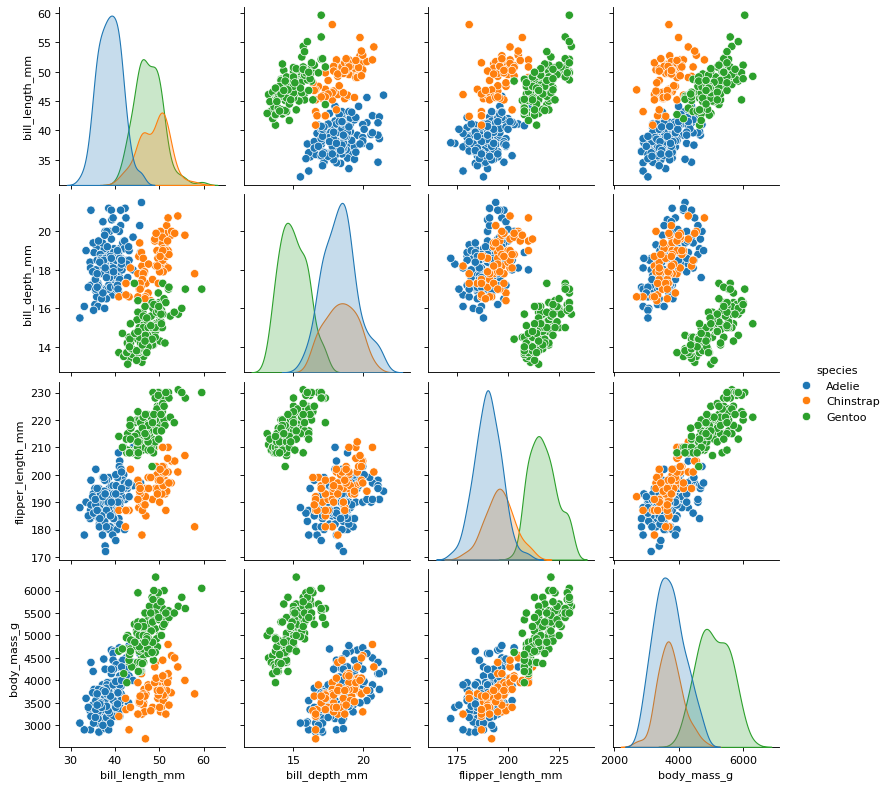

In [ ]:
# Plotting the data set
sns.pairplot(data = penguins_rm, hue = "species")

### **Solution**

- Basically, the species **Gentoo** is more separable when we look at the created scatterplots, compared to other two species. 

- Specifically, when the set of predictors **bill_depth - flipper_length**, **bill_depth - body_mass** or **flipper_length - bill_depth**, Gentoo species seems to be perfectly separable. One can even think of SVC linear setting while classifying Gentoo and other two species as Non-Gentoo

- In some cases (based on our predictor selection), the better separation on the **Adelie** and **Chinstrap** species is expected as well (ie. bill_length and bill_depth)

- One can use all the predictors in the feature space or alternatively, can focus on the general properties such as **bill_depth**, **flipper_length**. Generally, predictors have different ranges so they require some scaling when they are considered for the model (possibly)

### 🚩 Exercise 2  (CORE)

Consider the following decision tree fit on the penguins data, based on the selected predictors and try to answer the followings;

- What is the meaning of **max_depth** in the given code snippet ?

- Identify the predictor selected in the top/root node

- State the **type of nodes** illustrated below

- What is the meaning of the numbers inside of Value for each node ?

In [ ]:
# Some selection on data
X = penguins_rm.drop(["island", "sex", "species", "body_mass_g"], axis=1)
y = penguins_rm.species 

[Text(0.5, 0.8333333333333334, 'X[2] <= 206.5\ngini = 0.638\nsamples = 333\nvalue = [146, 68, 119]'),
 Text(0.25, 0.5, 'X[0] <= 43.35\ngini = 0.429\nsamples = 208\nvalue = [144, 63, 1]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.067\nsamples = 145\nvalue = [140, 5, 0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.148\nsamples = 63\nvalue = [4, 58, 1]'),
 Text(0.75, 0.5, 'X[1] <= 17.65\ngini = 0.107\nsamples = 125\nvalue = [2, 5, 118]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 118\nvalue = [0, 0, 118]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.408\nsamples = 7\nvalue = [2, 5, 0]')]

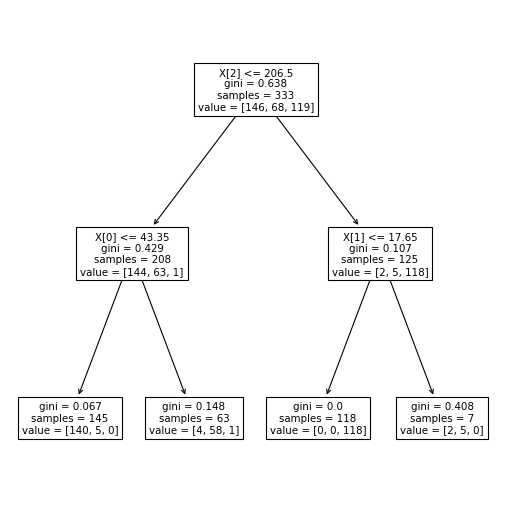

In [ ]:
# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)
# Once trained, you can plot the tree with the plot_tree function
tree.plot_tree(tree_clf)


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


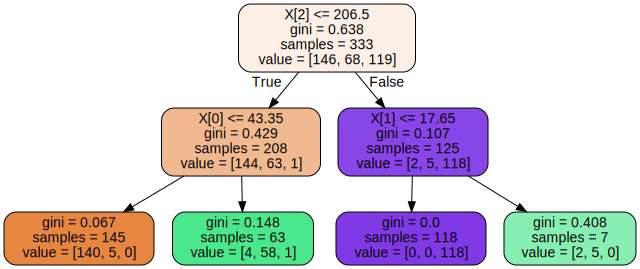

In [ ]:
# For plotting in a fancy way
! pip install graphviz

# You can visualize the trained Decision Tree with the following code snippet as well
from sklearn.tree import export_graphviz
import graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

graph = graphviz.Source(tree_data) 
graph

### **Solution**

In this fitted decision tree we have the following properties;

- `max_depth` stands for The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Herein, it is fixed as 2 that is the reason why we have the number of depth as 2 in the illustration (Depth 0 is the top nood, depth 1 is the further branching after the first split)

- In the top node we have the selected predictor `X[2]` from our feature space that is `flipper_length_mm` based on the order of available predictors. In that sense, such a plot seems to require further modification to get a better one

- The top node starts with the split wrt `X[2]` at the top as the name suggest. We have 2 internal nodes therafter including `X[0]` and `X[1]` with different conditions. Since `max_depth` is fixed here, most likely there will be further splits from the nodes at the bottom (recent child nodes) except the purple one, since it is an example of the leaf node (having Gini = 0, pure node)

- Those numbers correspond to the class labels belonging to three different species in this setting. In terms of the order of species names, Adelie-Chinstrap-Gentoo, we can observe the classified label frequency under the given split of the nodes. To illustrate, the leaf node having gini = 0 says that all the samples are classified as Gentoo species whereas there is no predicted class label for Adelie and Chinstrap under this node (Value = [0,0,118]) 

### 🚩 Exercise 3  (CORE) <a id='gini'></a>

Related to the information gain calculation, we have Gini or entropy impurity

- Work out on the calculations of the related Gini index values in the leaf nodes for the given output

- Compare your results with your own calculations. Do they match exactly or not ?

- Update the above code snippet by changing the criterion from **Gini** to **Entropy** in the main function and get the similar output- Update the above code snippet by changing the criterion from **Gini** to **Entropy** in the main function and get the similar output

**RECALL**

- **Gini Index**: It is a measure of total variance across the $K$ classes, defined as follows:

$G = \sum_{k=1}^{K} \widehat{p}_{mk} (1 - \widehat{p}_{mk}) = 
1 - \sum_{k=1}^{K} \widehat{p}_{mk}^2$ 

where $\widehat{p}_{mk}$ is the proportion of training observations in the $m$'th region (belong to $mth$ node) coming from the $k$'th class.

- **Entropy**: It is an alternative to Gini Index and defined as; 

$D = - \sum_{k=1}^{K} \widehat{p}_{mk} \log \widehat{p}_{mk}$
where the range of $\widehat{p}_{mk}$ guarantees that $0 \leq - \widehat{p}_{mk} \log \widehat{p}_{mk}$.

### **Solution**

We can manually get the values using the given information in the illustration or try to extract relevant values directly

In [ ]:
# For one of the leaf nodes we have the following 
# To illustrate, the far bottom right we have X1 <= 17.65 is false 
# values are [2,5,0]
Gini_leaf = 1 - (2/7)**2 - (5/7)**2 - (0/7)**2
print(Gini_leaf)

0.40816326530612246


In [ ]:
# To exemplify the Gini index calculation on one of the terminal nodes
# having X[0] <= 43.35

Gini_terminal = 1 - (144/208)**2 - (63/208)**2  - (1/208)**2
print(Gini_terminal)

0.4289478550295858


In [ ]:
# Alternatively to extract only
# The impurity values for all nodes are also accessible in the impurity attribute of the tree.
tree_clf.tree_.impurity

array([0.6383681 , 0.42894786, 0.0665874 , 0.14814815, 0.107008  ,
       0.        , 0.40816327])

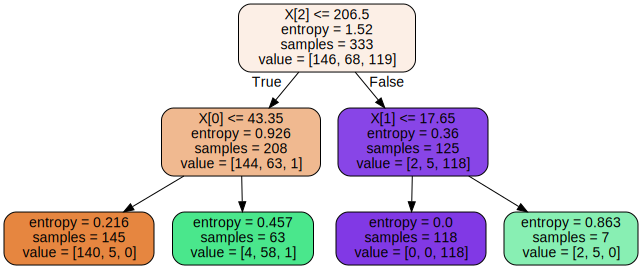

In [ ]:
# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth = 2, criterion = 'entropy')
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

In [ ]:
tree_clf.tree_.impurity

array([1.52008355, 0.92621936, 0.21639693, 0.45723393, 0.35969212,
       0.        , 0.86312057])

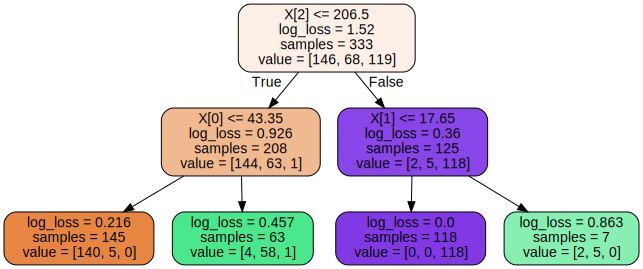

In [ ]:
# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth = 2, criterion = 'log_loss')
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

- Log-loss and entropy are the same under this setting


🏁 Now, is a good point to switch driver and navigator

### 🚩 Exercise 4  (CORE)

What is the accuracy of the fitted decision tree above over the 5-fold CV? 

<details><summary><b><u>Hint</b></u></summary>
    
- You can use simply the function of  `cross_val_score`
    
</details>



In [ ]:
from sklearn.model_selection import cross_val_score

cv_5 = cross_val_score(tree_clf, X, y, cv = 5)

print(cv_5)
print(np.mean(cv_5))

[0.97014925 0.94029851 0.94029851 0.92424242 0.95454545]
0.945906829488919


- Briefly, the mean accuracy over the 5fold of considered tree fit seems satisfactory enough

### 🚩 Exercise 5 (CORE)

Play around some of the input arguments, such as

- `max_depth`

- `min_samples_split`

- `min_samples_leaf`

- `max_leaf_nodes`

- `min_impurity_decrease`

by changing their values

- Rerun different models with such selections and compare / observe their performances briefly

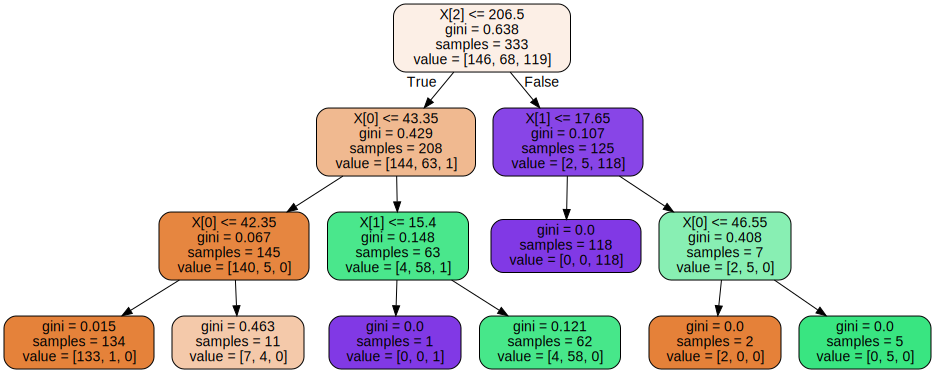

In [ ]:
# Some experiments in general

# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

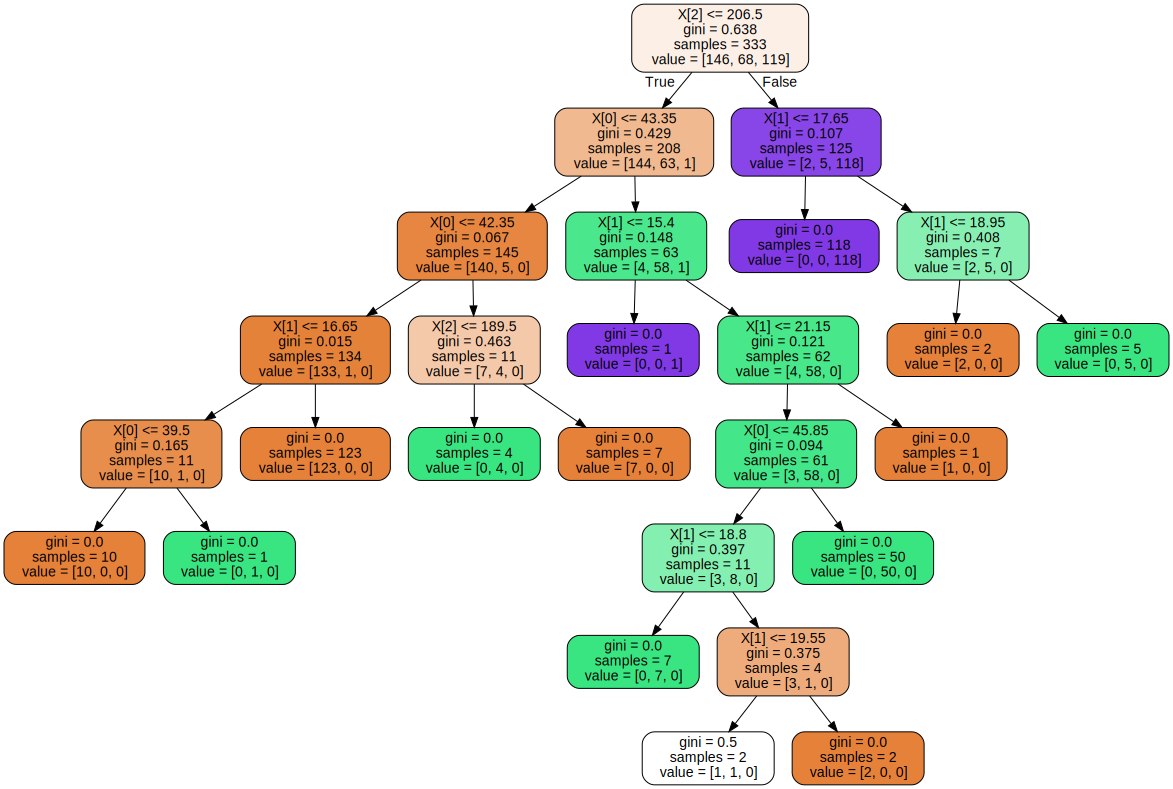

In [ ]:
# Some experiments in general

# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(min_samples_split=3)
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

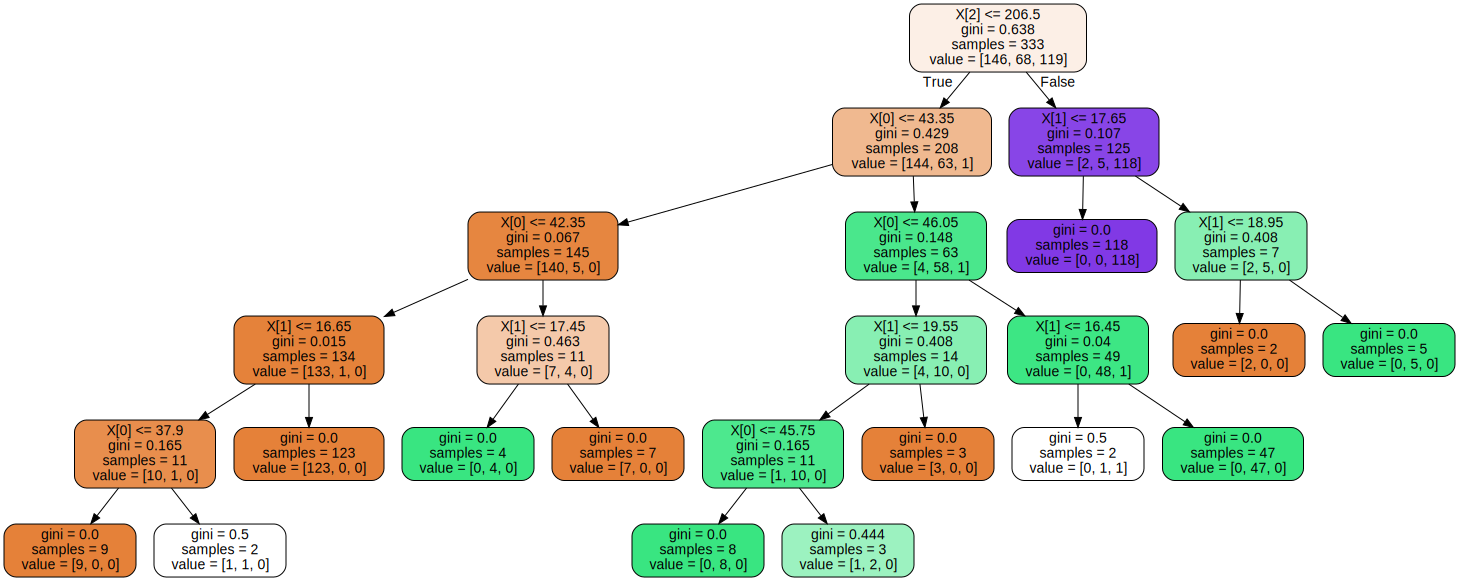

In [ ]:
# Some experiments in general

# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(min_samples_leaf=2)
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

Briefly, it is important to digest the meanings of about hyperparameters while changing their values

- `max_depth` : The maximum depth of the tree. 

- `min_samples_split` : The minimum number of samples required to split an internal node

- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

- `max_leaf_nodes`: Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

🏁 Now, is a good point to switch driver and navigator

# 3. Ensemble I: Bagging  <a id='majVot'></a> 

A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. To apply bagging to decision trees, we simply construct 
(i) decision trees using bootstrapped training sets,
(ii) take a majority vote of the resulting predictions.

- A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

- Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- Specifically, bagging is when sampling is produced with replacement, and without replacement being called pasting

- Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory

- Both bagging and pasting allow training to be sampled several times across multiple predictors, with bagging only allowing several samples for the same predictor

- Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers

- Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

For some details on sklearn, please see that webpage 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html




### 🚩 Exercise 6  (CORE)

Execute the following code and try to answer the followings:

- What is the predicted class labels based on given Bagging model, using the same predictors that we used in Exercise 2

- How do you predict a new data having $(bill\_length\_mm,bill\_depth\_mm,flipper\_length\_mm)$ = (15.6, 34.7, 185.4) ? 

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Updating X and y again
# Some selection on data
X = penguins_rm.drop(["island", "sex", "species", "body_mass_g"], axis=1)
y = penguins_rm.species 

clf = BaggingClassifier(n_estimators=10, random_state=42).fit(X, y)

In [ ]:
# The predicted probabilities
clf.predict_proba(X)
# The predicted classes for each observation
# clf.predict(X)

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.9, 0.1, 0. ],
       [1. , 0. , 0. ],
       [0.7, 0.3, 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0.9, 0.1, 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. 

In [ ]:
print(clf.predict_proba([[15.6, 34.7, 185.4]]))

print(clf.predict([[15.6, 34.7, 185.4]]))

[[1. 0. 0.]]
['Adelie']
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


- It is basically classifies as Adelie species, the one having (bill_length_mm, bill_depth_mm, flipper_length_mm) = (15.6, 34.7, 185.4)

---

### 🚩 Exercise 7  (CORE)

Based on the above fitted model,

1. Calculate the out-of-bag score

2. Examine the impact of `n_estimators` by using different values in $(1, 100, 1000)$

3. Compare all the out-of-bag scores of all fitted models under different `n_estimators` values

In [ ]:
clf = BaggingClassifier(n_estimators=10, random_state=42, oob_score=True).fit(X, y)
print(clf.oob_score_)

In [ ]:
# Changing the value of n_estimators 
# For 1
clf = BaggingClassifier(n_estimators=1, random_state=42, oob_score=True).fit(X, y)
print(clf.oob_score_)

# For 100
clf = BaggingClassifier(n_estimators=100, random_state=42, oob_score=True).fit(X, y)
print(clf.oob_score_)

# For 10000
clf = BaggingClassifier(n_estimators=1000, random_state=42, oob_score=True).fit(X, y)
print(clf.oob_score_)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:753: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
0.6546546546546547
0.96996996996997
0.9669669669669669


- Herein, not a big change occured in the out of bag scores in general, except the case of n_estimators = 1. 

- Is there a possible way to get more improvement playing around the other input parameters ? 

## 4. Ensemble II: RandomForest

Random forests are among the most widely used machine learning algorithm. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. The random forest algorithm can therefore be summarized in four steps;

- Draw a random bootstrap sample of size $n$

- Grow a decision tree from the bootstrap sample. At each node:
    * Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
    * Split the node using the feature that provides the best split according to the objective function.

- Repeat the steps above $k$ times.

- Aggregate the prediction by each tree to assign the class label by majority vote.


**NOTES** 

- The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.

- Random forests fit decision trees on different bootstrap samples, and for each decision tree, select a random subset of features at each node to decide upon the optimal split. The feature subset to consider at each node is a hyperparameter that we can tune

- Instead of using majority vote, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.

- Notice that if a random forest is built using all features, then this is simply bagging.

- you can also bootstrap features in the `BaggingClassifier` using `bootstrap_features=True`

- By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other.

- If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities

### Related Hyperparameters

Important parameters to adjust are;

- `n_estimators`: Larger is generally better as averaging more trees will typically yield a more robust ensemble by reducing overfitting.
- `max_features`: Determines how random each tree is so smaller number of features at each split reduces overfitting.
- `max_samples`: Sample size of the bootstrap sample, also reduces overfitting. pre-pruning options (`max_depth`, `max_leaf_nodes`): more important for single trees, but can improve performance, reduce space, and time requirements.

**NOTES**

- Typically you want to use as many estimators as you have time and memory for training.

- A good rule of thumb for `max_features` default values are `max_features=sqrt(n_features)` for classification and `max_features=n_features` for regression

- "Segal (2004) showed that if your data has many noisy predictors and higher `[max_features]` values are performing best, then performance may improve by increasing node size (i.e., decreasing tree depth and complexity). Moreover, if computation time is a concern then you can often decrease run time substantially by increasing the node size and have only marginal impacts to your error estimate..."

- Small bootstrap samples do tend to produce worse models

For a more thorough discussion of forest hyperparameters, see: Probst, Philipp, Bernd Bischl, and Anne-Laure Boulesteix. 2018. “Tunability: Importance of Hyperparameters of Machine Learning Algorithms.” arXiv Preprint arXiv:1802.09596.

### 🚩 Exercise 8 (CORE)

Consider the above problem under Random Forest approach simply using the `RandomForestClassifier()` function adjusting the **max_depth** value

You can compare it in terms of out of bag scores for the simple comparison and possible to play around input arguments of the new classifier function.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 2, random_state=42, oob_score=True)
clf.fit(X, y)
print(clf.oob_score_)

0.954954954954955


- If we have a look at the model with `max_depth=2` we observe the oob score as 0.95

-  when we increase the max_depth, there exists a certain improvement up to a certain level, such as 6

---
 
### 🚩 Exercise 9 (CORE)

Set up a function for experimenting with different n_estimators and max_depth. For this purpose, consider, 

1. **n_estimators** in $[1,10,100, 1000]$
2. **max_depth** in $[2, 3, 4]$

Find the final out-of-bag score based on the optimal one based on your comparison on the accuracy

In [ ]:
# By adding the cv as well

model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid = { 
        'n_estimators': [1, 10, 100, 1000],
        'max_depth': [2, 3, 4]
    }
)

# Fit the model on ex4 data set
model.fit(X, y)

# Get the best model parameters and the accuracy of the model
print("Params: ", model.best_params_)
print("Avg Accuracy: ", model.best_score_)

Params:  {'max_depth': 4, 'n_estimators': 100}
Avg Accuracy:  0.9669380370872908


In [ ]:
clf = RandomForestClassifier(max_depth = 4, random_state=42, n_estimators = 100, oob_score=True)
clf.fit(X, y)
print("Out of bag score: ", clf.oob_score_)

Out of bag score:  0.96996996996997


# 5 Voting Classifier

Majority voting can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes). Majority vote refers to binary class decisions but can be generalized to a multi-class setting using plurality voting

In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier. Simply

E.g., if the prediction for a given sample is

- classifier 1 -> class 1

- classifier 2 -> class 1

- classifier 3 -> class 2

the VotingClassifier (with voting='hard' by default) would classify the sample as “class 1” based on the majority class label.

**NOTES**

- Scikit-learn uses the `predict_proba` method to compute class probabilities.

- "In decision trees, the probabilities are calculated from a frequency vector that is created for each node at training time. The vector collects the frequency values of each class label computed from the class label distribution at that node. Then, the frequencies are normalized so that they sum up to 1... Although the normalised probabilities returned by both the decision tree and k-nearest neighbors classifier may look similar to the probabilities obtained from a logistic regression model, we have to be aware these are actually not derrived from probability mass functions."

For further details, please see the documentation from here: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

---

### 🚩 Exercise 10  (EXTRA)

- Complete the following code snippet with your RandomForest and Bagging model selection above

- Look at the accuracy score of the each model and voting classifier one, is there any improvement with voting classifier or not ?


In [ ]:
# As an example for different models 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Your bagging model
bag_clf = BaggingClassifier(n_estimators=100, random_state=42, oob_score=True)

# Your random forest model
rnd_clf = RandomForestClassifier(max_depth = 4, random_state=42, n_estimators = 100, oob_score=True)

# Default SVC model
svm_clf = SVC()

voting_clf = VotingClassifier(
 estimators=[('bag', bag_clf), ('rf', rnd_clf), ('svc', svm_clf)],
 voting='hard')

voting_clf.fit(X, y)

VotingClassifier(estimators=[('bag',
                              BaggingClassifier(n_estimators=100,
                                                oob_score=True,
                                                random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=4,
                                                     oob_score=True,
                                                     random_state=42)),
                             ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (bag_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(clf.__class__.__name__, accuracy_score(y, y_pred))

BaggingClassifier 1.0
RandomForestClassifier 0.987987987987988
SVC 0.7867867867867868
VotingClassifier 0.996996996996997


- Herein, the voting classifier idea performs better than SVC and RandomForest

- Bagging classifier has the largest accuracy under this setting, might need further investigation and remember that for the penguins toy data we did not apply any data splitting!

# 6 Breast Cancer Data Case <a id='cancer'></a>

Load and return the breast cancer wisconsin dataset (classification). The breast cancer dataset is a classic and very easy binary classification dataset since we have two cancer types, WDBC-Malignant and WDBC-Benign.

You can find other details about the data set from here: https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset




In [ ]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

---

### 🚩 Exercise 11 (CORE)

1. Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $30\%$ of the whole sample

2. Consider a `DecisionTree classifier` on the training data set using all features

3. Compute the pruning path during `Minimal Cost-Complexity Pruning`. Examine and explain your findings

Note that 

- Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. 

- To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. 

- As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

<details><summary><b><u>Hint</b></u></summary>
    
- You can use simply the function of  `cost_complexity_pruning_path`
    
- See further details from here: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
    
</details> 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    test_size = 0.3, random_state=42)

In [ ]:
DT = DecisionTreeClassifier(criterion='gini', random_state=42)
DT.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
path = DT.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# The complexity controlling parameter
print(ccp_alphas)
# Corresponding node impurities
print(impurities)

[0.         0.00249033 0.00335008 0.00491483 0.00635319 0.0080402
 0.01072027 0.0143575  0.01623502 0.01716941 0.01852043 0.0281733
 0.33063959]
[0.         0.00996131 0.01331139 0.01822623 0.02457942 0.03261962
 0.04333989 0.05769739 0.07393241 0.09110182 0.10962226 0.13779555
 0.46843514]


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

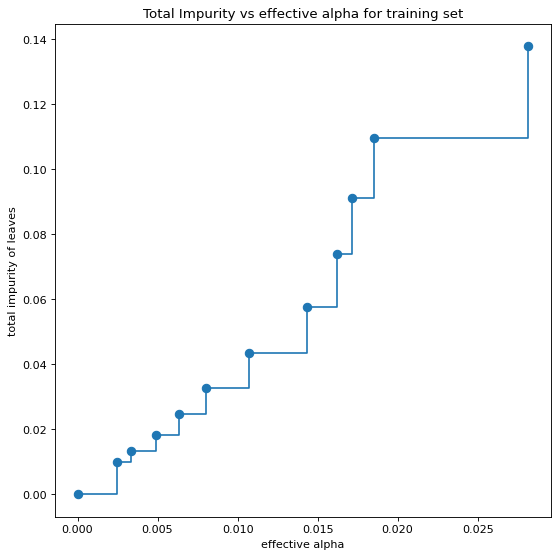

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
#print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# print(clfs)

# Score on the training based on alpha values
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

print(train_scores)
print(test_scores)

[1.0, 0.9949748743718593, 0.992462311557789, 0.9899497487437185, 0.9874371859296482, 0.9824120603015075, 0.9698492462311558, 0.9597989949748744, 0.9447236180904522, 0.9422110552763819, 0.9396984924623115, 0.9246231155778895, 0.6256281407035176]
[0.9415204678362573, 0.9590643274853801, 0.9590643274853801, 0.9649122807017544, 0.9649122807017544, 0.9649122807017544, 0.9590643274853801, 0.9415204678362573, 0.9415204678362573, 0.9298245614035088, 0.9064327485380117, 0.8947368421052632, 0.631578947368421]


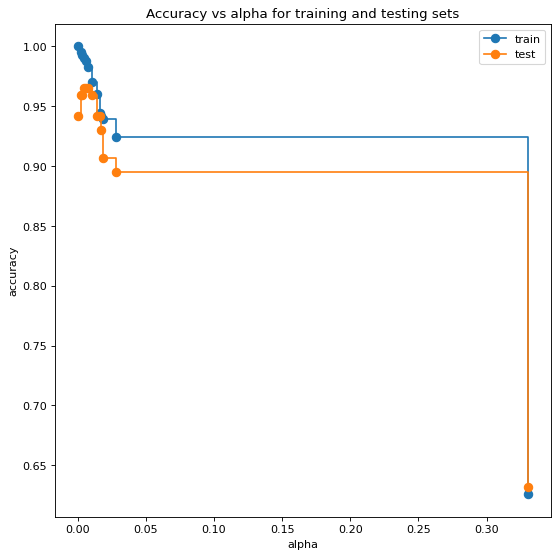

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### 🚩 Exercise 12 (EXTRA)

Inside of pruning path during (in the output of `cost_complexity_pruning_path`), we have different applicable alpha values and corresponding impurity in the leaf nodes introduced. This contains two Numpy Arrays of alpha and impurities in general. Using the obtained values, 

- Simply plot that relationship based on alpha and corresponding impurity values

- Find an optimal value of alpha by using the model accuracy (looking at the test data performance mainly)

- With this selected alpha value, consider RandomForestClassifier rather than the DecisionTreeClassifier to create a new ensemble model

- Calculate the variable importance by using `feature_importances_` and visualize. You can benefit from the example given here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

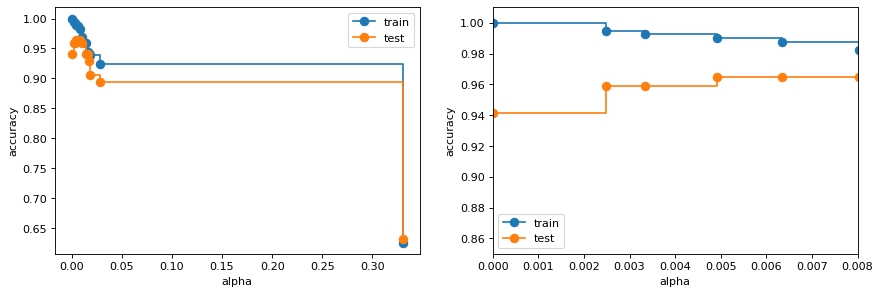

In [ ]:
# golden ratio for figures ()
gr = 1.618

# Some figure modification parameters
height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

fig, axes = plt.subplots(ncols=2, figsize = (width_inch*2, height_inch))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    if i ==1:
        ax.set_xlim(0.,0.008)
        ax.set_ylim(0.85,1.01)

In [ ]:
# Making a rough selection over the plots
print(clfs[3])

DecisionTreeClassifier(ccp_alpha=0.0049148318490037, random_state=42)


In [ ]:
# Then we can train a decision tree using the chosen effective alpha.
RF_ccp = RandomForestClassifier(criterion='gini',
                               random_state=42,
                               ccp_alpha = 0.0049                            
                              )

RF_ccp.fit(X_train, y_train)
# Score on the training based on alpha values
train_scores = RF_ccp.score(X_train, y_train)
test_scores = RF_ccp.score(X_test, y_test)

print(train_scores)
print(test_scores)

0.992462311557789
0.9649122807017544


In [ ]:
# ABOUT FEATURE IMPORTANCE IDEA 
# get the importances for the features
importances = RF_ccp.feature_importances_

importances_series = pd.Series(importances, index=list(X.columns)).sort_values(ascending = False)
importances_series.head() 

mean concave points     0.148156
worst concave points    0.131389
worst area              0.122257
mean concavity          0.083126
worst radius            0.080249
dtype: float64

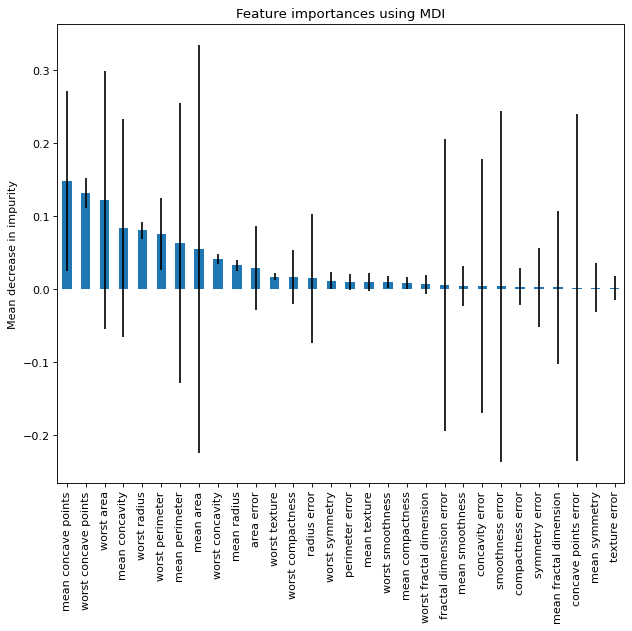

In [ ]:
import time
import numpy as np

importances = RF_ccp.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_ccp.estimators_], axis=0)

fig, ax = plt.subplots()
importances_series.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This illustration mainly shows the importance of features on the created randomforest model fit with the selected alpha value. 

- The blue bars are the feature importances of the given model, along with their inter-trees variability represented by the error bars.

- The first three important variables determined as `mean concave points`, `worst concave points` and `worst area` having value larger than 0.10 

- Comparatively, among these three variables, **worst area** has the larger inter-trees variability, denoted by thinner black lines on top of the blue bars

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name. If you are unable to edit the Notebook Metadata, please add a Markdown cell at the top of the notebook with your name(s).

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [ ]:
!jupyter nbconvert --to pdf mlp_week08_key.ipynb 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>